<a href="https://www.kaggle.com/leandrodestefani/house-price-predictions-with-regression-vietnam?scriptVersionId=84999443" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## House Price Prediction with Regression and Random Forest


### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


## Loading Data

In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print(df.shape)

(1460, 81)


Our dataset has 1460 rows and 81 columns.

## Exploring and Cleaning Data

We can see some features are numeric while others are text. There are also missing values in dataset.

In [4]:
# Find columns with missing values and their percent missing

df.isnull().sum()
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissValCount'])
miss_val

,MissValCount
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
...,...
ExterQual,0
Exterior2nd,0
Exterior1st,0
RoofMatl,0


In [5]:
# Add a new column to the DataFrame and fill it with the percentage of missing values
miss_val['Percent'] = miss_val['MissValCount'].apply(lambda x: '{:.2f}'.format(float(x)/df.shape[0]*100))
miss_val = miss_val[miss_val['MissValCount'] > 0]
miss_val

,MissValCount,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


We'll remove those features with a high percent ofmissing values such as PoolQC, MiscFeature, Alley, Fence and FireplaceQu. Note that the LotFrontage feature has only 16% missing. This is realtively low so we can choose to replace the NaN values with the imputed mean of the column. We will remove the remainder rows with missing values.

In [6]:
# drop columns with high percentage of missing values

df = df.drop(columns=['PoolQC', 'Fence', 'Alley', 'MiscFeature', 'FireplaceQu'], axis=1)

In [7]:
# drop rows with any missing values
df.dropna(inplace=True)

In [8]:
# Check the dimension of the dataset
df.shape

(1094, 76)

The dataset is cleaned. It now has 1094 observations and 76 features.

## Exploring Data

Let's examine the data distributions of the features. We will start with the target variable, **SalePrice**, to make sure it's normal distribute.d This is an important step because most Machine Learning algorithms make the assumption that the data is normal distributed. When data fits a normal distribution, we can make statements about the population using analytical techniques.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


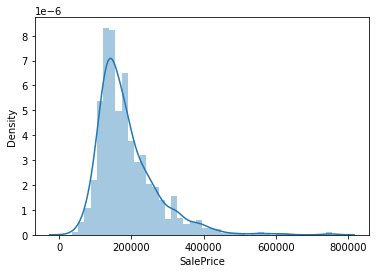

In [9]:
# Check distribution of target variable
sns.distplot(df.SalePrice)
plt.show()

We can see the SalePrice distribution is skewed to the right. Let's transform it so that it follows a gaussian normal distribution.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


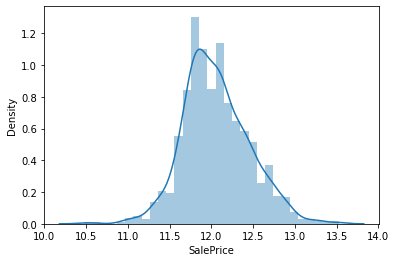

In [10]:
sns.distplot(np.log(df.SalePrice))
plt.show()

The data is now more normal distributed. We can use this transformed data in the dataframe and remove the skewed distribution.

In [11]:
df['LogOfPrice'] = np.log(df.SalePrice)
df.drop(['SalePrice'], axis=1, inplace=True)

## Train-Test Split Dataset

Before we can start modeling the data, we need to split the dataset into training and test sets. We will train the models with the training set and cross-validate with the test set. Recall we have lots of features in the dataset that are text. most machine learning models require numerical input features. Since the process of converting text features to a numeric representation an involved task, we will only use the numeric features in our price prediction (for simplicity sake).

In [12]:
# set the target and predictors

y = df.LogOfPrice  # target

# use only those input features with numeric data type
df_temp = df.select_dtypes(include=['int64', 'float64'])
X = df_temp.drop(['LogOfPrice'], axis=1) # predictors

To split the dataset, we will use random sampling with 75/25 train-test split; that is, we'll use 75% of the dataset for training and set aside 25% for testing:

In [13]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=3)

## Linear Regression

In [14]:
lr = LinearRegression()
# fit optimal linear regression line on training data, this performs gradient decent under the hood
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# given our model and out fit, predict y_values using X_test set

yr_hat = lr.predict(X_test)

In [16]:
# evaluate the algorithm with a test set
lr_score = lr.score(X_test, y_test)
print("Accuracy: ", lr_score)

Accuracy:  0.886663711473874


Let's see how well the train-test split method performed. We will do cross-validation to see whether the model is over-fitting the data:

In [17]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying

lr_cv = cross_val_score(lr, X, y, cv=5, scoring = 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.88426462 0.83605032 0.86145344 0.89201551 0.6154792 ]
R2:  0.8178526186867081


It doesn't appear that for this train-test dataset, the model is not over-fitting the data (the cross-validation performance is very close in value). It may be a slightly over-fitted but we can't really tell by the R-squared metric alone. If it is over-fitted, we can do some data transforms or feature engineering to improve its performance. But our main objective initially is to spot-check a few algorithms and fine tune the model later on.

To help prevent over-fitting in which may result from simple linear regression, we can use regression moedls with regularization. Let's look at ridge and lasso next.

## Random Forest

In [18]:
#rfr = RandomFoRandomForestRegressor (n_estimators=100, max_depth=5, min_samples_leaf=5, max_features='sqrt') # using GridSearch

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr, X, y, cv=5, scoring='r2')
print("R2: ", rfr_cv.mean())

R2:  0.860406809741991


Random Forest is an advanced decision tree based machine learning. It has a classification and a regression random forest algorithm. Its performance is slightly better than regression. Like regularization, we can optimize the model parameters for best performance using gridsearch.

In [19]:
# Random forest determined feature importances
rfr.feature_importances_

array([6.65476181e-03, 3.11491732e-03, 1.13757329e-02, 2.03022381e-02,
       5.83228906e-01, 1.91843687e-02, 1.70535225e-02, 2.74658402e-02,
       3.71946124e-03, 1.76475219e-02, 4.14078048e-04, 6.84306467e-03,
       3.70603302e-02, 3.29789118e-02, 1.09940031e-02, 1.44967811e-05,
       8.24679656e-02, 1.46327021e-03, 2.60743983e-04, 5.31817176e-03,
       1.04781753e-03, 1.76520280e-03, 1.60728547e-03, 4.17773042e-03,
       4.12492835e-03, 9.63006055e-03, 4.33180837e-02, 2.26940299e-02,
       5.50267616e-03, 5.82726453e-03, 2.85374796e-03, 2.80929558e-04,
       7.47490268e-04, 5.23948480e-04, 5.25499086e-04, 5.46686318e-03,
       2.34413509e-03])

## Plotting the Feature Importance

Let's see the features that are the most promissing predictors:

In [20]:
importance = rfr.feature_importances_

# map feature importance values to the features

feature_importances = zip(importance, X.columns)
# list(feature_importances_)

sorted_featured_importances = sorted(feature_importances, reverse=True)
#print(sorted_featuredfeature_importances)

top_10_predictors = sorted_featured_importances[0:10]
values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print(predictors)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'GarageArea', 'LotArea', 'OverallCond', 'BsmtFinSF1']


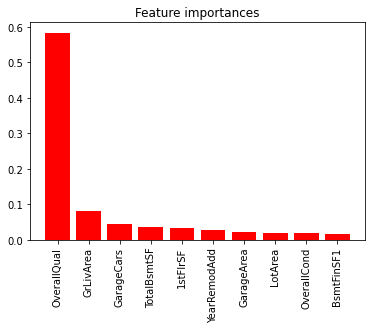

In [21]:
# Plot the feature importance of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.show()

In [22]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test = test.select_dtypes(include=['int64', 'float64'])
test.dropna(inplace=True)
y_pre = rfr.predict(test[100:110])
count=0
for i in y_pre:
    count+=1
    print('The price of the house ' + str(count) + ' is: '  + str(np.exp(i)) + '$')

The price of the house 1 is: 127325.43460451488$
The price of the house 2 is: 331056.5288224204$
The price of the house 3 is: 248705.70228875437$
The price of the house 4 is: 86729.1863751952$
The price of the house 5 is: 98518.93728697584$
The price of the house 6 is: 140121.74595285908$
The price of the house 7 is: 105055.95730531294$
The price of the house 8 is: 140609.75980377957$
The price of the house 9 is: 130019.52079034125$
The price of the house 10 is: 238484.86789131246$


### Saving Predictions and Creating Submissions

Let's save our predictions and submit then to a CSV file.

In [23]:
predictions = rfr.predict(test)
print(len(predictions))
print(len(test))

1146
1146


In [24]:
output = pd.DataFrame({'Id': test.index, 'SalePrice': np.exp(predictions)})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Conclusion

Random Forest is the most accurate model for predicting the house price. It scored an estimated accuracy of 85%, outperforming the Linear Regression's accuracy (81%).